In [5]:
from scipy.integrate import quad
import numpy as np
from scipy.integrate import odeint
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import integrate
import matplotlib.ticker
from accretion import*
from vrel import*
import math
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})



def m_acc_Luca_vrel_digitized(t, m):  
    z = t
    y = np.array(m, dtype = np.longdouble)
    
    if z < 0 or z == 0:
        print("i =",   i, ",", "z =", z)
        
    def c_s_digitized(z):
        return  c_s_extrapolation(z) * 1e3 *  (yr/pc)
    
    
    def v_rel_digitized(z):
        return  vrel_extrapolation(z) * 1e3 *  (yr/pc)
   
    #print("v_rel_digitized(z) =", v_rel_digitized(z))
        
    def Mach_number(z):
        return v_rel_digitized(z)/c_s(z)
     
    
    if less_efficient_accretion == True:
        def v_eff(z):
            if Mach_number(z) > 1:
                return  c_s(z) * (((16/np.sqrt(2 * np.pi)) * (Mach_number(z)**3))**(1/6))  
            else:
                return  c_s(z) * np.sqrt(1 + (Mach_number(z)**2))
    else:
        def v_eff(z):
            e = 2.71828
            if Mach_number(z) > 1:
                return  c_s(z) * Mach_number(z) * ((np.sqrt(2/np.pi) * np.log((2/e) * Mach_number(z)))**(-1/3))  
            else:
                return  c_s(z) * np.sqrt(1 + (Mach_number(z)**2))

   
    def β_cap(z, m):
        x_e = 1e-3
        return 1e-4 * y * (((1+z)/1000)**(3/2)) *  (((5.74e3 * (yr/pc))/v_eff(z))**3) * (0.257 + 1.45 * (x_e/0.01) * (((1+z)/1000)**(5/2)))
    
   
    def x_cr(z, m):
            return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m) 
    
    def k(z, m):
        def M_halo(z, m):
            return 3 * y * ((1+z/1000)**(-1))
        return 0.22 * ((1+z)/1000) * (M_halo(z, m)**(2/3)) * (((1e3 * (yr/pc))/v_eff(z))**2)

    
    if k(z, m)< 2:
        def λ(z, m):
            alpha = 2.25
            p = 2 - alpha
            power = p/(1-p)
            def β_cap_halo(z, m):
                return (k(z, m)**power) * β_cap(z, m)
            def x_cr_halo(z, m):
                return ((k(z, m)/2)**power) * x_cr(z, m)
            def gamma_bar(z, m):
                return ((1 + 10 * β_cap_halo(z, m))**(1/10)) * np.exp(2 - k(z, m)) * ((k(z, m)/2)**2)
            return (gamma_bar(z, m)**power) * np.exp((9/2)/(3 + β_cap_halo(z, m)*(0.75))) * (x_cr_halo(z, m)**2)
    
    else:
        def λ(z, m):
            return np.exp((9/2)/(3 + β_cap(z, m)*(0.75))) * (x_cr(z, m)**2)
        
    
    def m_dot(z, m):  #Eq.(11) in https://arxiv.org/abs/2003.12589
        return   2.4e-2 * λ(z, m) * ((1+z)/1000) *  y * (((5.74e3 * (yr/pc))/v_eff(z))**3) 

    def dt_dz(z):
        factor = ((Ω_r0 * ((1 + z)**6)) + (Ω_m0 * ((1 + z)**5)))
        return  - np.sqrt(3/(8 * π * G * ρ_c0)) * (factor**(-1/2))
    
    return 2e-3 *  m_dot(z, m) * (y/1e6) *  dt_dz(z)

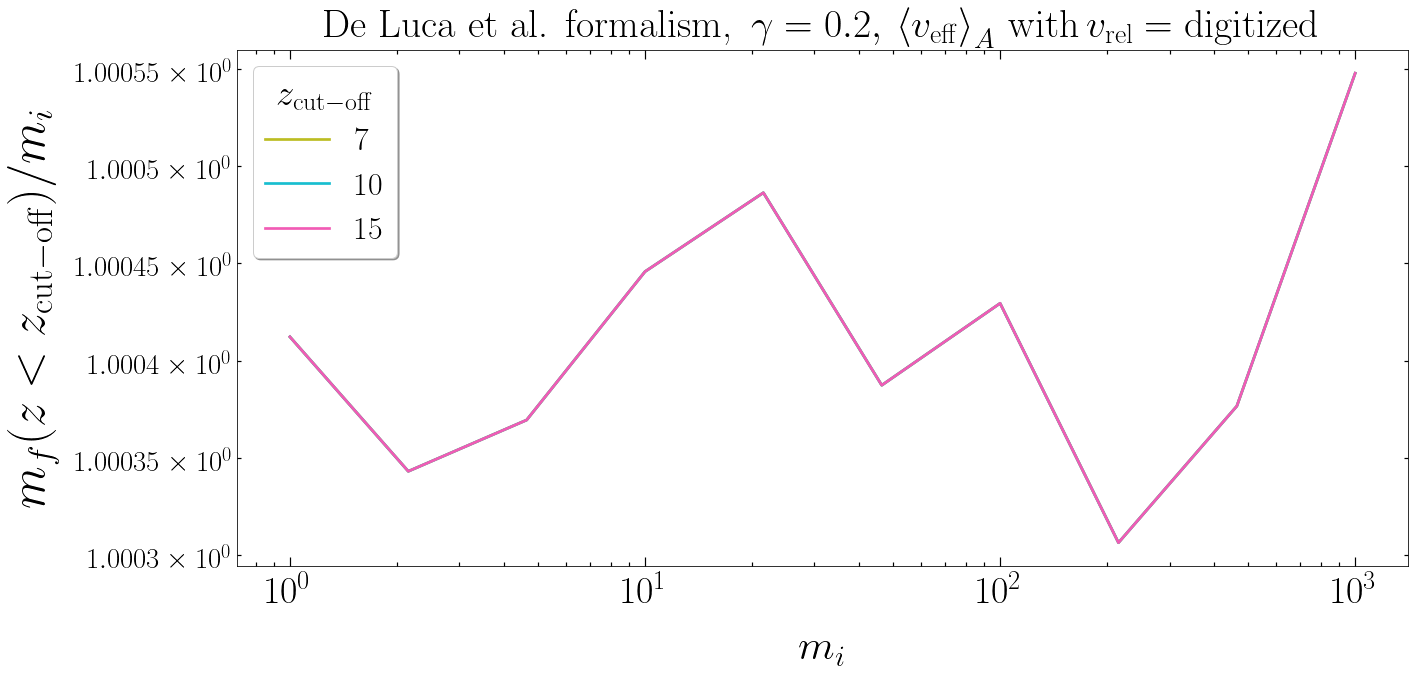

In [6]:
# Baryon accretion as per as per eq. (10) and (11) of Luca et. al https://arxiv.org/pdf/2003.12589.pdf 
# to upto z_cut-off = 5.
# Here, m_f(z < z_cut-off)/m_i implies  m_f(z = z_cut-off)/m_i.



m_spacing = 10
mi_arr = np.geomspace(1, 1e3, m_spacing)





fig,ax = plt.subplots(1, figsize = (21, 9.5))
plt.rc('lines', linewidth = 2.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


z_cut_arr = np.array([7, 10, 15])
mf_arr = np.zeros(len(mi_arr))
colors = ['C8', 'C9',  '#f15bb5']
plot_lines = []
N = 10


for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    less_efficient_accretion = False
    for j, m in enumerate(mi_arr):
        γ = 0.2
        z_1i = z_pbh(m,  γ)
        y_1i = m
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, N)
        sol1 = solve_ivp(m_acc_Luca_vrel_digitized, t_span = [t1[0], t1[-1]], y0 = [y_1i], method = 'DOP853',  t_eval = t1)
        t1 = sol1.t
        y1 = sol1.y[0]
        
        mf_arr[j] = y1[-1]
        

        
    ax.loglog(mi_arr, np.divide(mf_arr, mi_arr), color = color)
        
        
       
    
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
ax.tick_params(axis = 'y', which = 'minor', labelsize = 29)
plt.xticks(fontsize = 38)
plt.yticks(fontsize = 38)
plt.xlabel('$m_{i}$',fontsize = 43, labelpad = 20)
plt.ylabel(r'$m_{f}(z < z_\mathrm{cut-off})/m_{i} $',fontsize = 50, labelpad = 16)
plt.legend(['$7$', '$10$', '$15$'], 
           prop = {'size':32}, loc = 'upper left', shadow = True, 
           title = '$z_\mathrm{cut-off}$' ,
           title_fontsize = 37, facecolor = 'white', fontsize = 65)
plt.xscale('log')
plt.title(r' De Luca et al. formalism, $\,\gamma = 0.2, \,\left\langle  v_\mathrm{eff} \right\rangle_{A}\, \mathrm{with} \, v_\mathrm{rel} = \mathrm{digitized}$', fontsize = 40, pad = 13)
plt.savefig('Luca_A.pdf', bbox_inches = 'tight')
plt.show()